<a href="https://colab.research.google.com/github/AbdulSheffa/IRP/blob/main/FYP_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix


In [3]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha

In [4]:
pip install pytorch_msssim

In [5]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
from models.networks import ResnetGenerator, NLayerDiscriminator
import pytorch_msssim  # Import for SSIM Loss
# import lpips

# ------------------------------
# 1. Dataset with Self-Supervised Learning & Masking
# ------------------------------
class RainDatasetSSL(Dataset):
    def __init__(self, dataset_name, input_dir, target_dir, transform=None, sample_size=None, output_dir=None, save_masked=False, epoch=0):
        self.dataset_name = dataset_name
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.output_dir = output_dir
        self.save_masked = save_masked
        self.epoch = epoch

        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))

        if sample_size:
            indices = random.sample(range(len(self.input_images)), sample_size)
            self.input_images = [self.input_images[i] for i in indices]
            self.target_images = [self.target_images[i] for i in indices]

        if save_masked and output_dir:
            os.makedirs(output_dir, exist_ok=True)
            self.masked_images_to_save = random.sample(self.input_images, min(10, len(self.input_images)))

    def __len__(self):
        return len(self.input_images)

    def mask_image(self, img_tensor, img_name):
        """Apply dynamic masking for self-supervised learning & save masked image if required."""
        if img_tensor.dim() == 4:  # If batch, process each image separately
            return torch.stack([self.mask_image(single_img, img_name) for single_img in img_tensor])

        if img_tensor.dim() != 3:
            raise ValueError(f"Unexpected tensor shape {img_tensor.shape}, expected (C, H, W)")

        _, h, w = img_tensor.shape
        mask_size = (random.randint(h // 6, h // 4), random.randint(w // 6, w // 4))
        x, y = random.randint(0, h - mask_size[0]), random.randint(0, w - mask_size[1])

        masked_tensor = img_tensor.clone()
        masked_tensor[:, x:x + mask_size[0], y:y + mask_size[1]] = -1

        # Ensure the output directory exists before saving
        if self.save_masked and self.output_dir:
            os.makedirs(self.output_dir, exist_ok=True)  # Ensure the directory exists

            save_path = os.path.join(self.output_dir, f"masked_{self.dataset_name}_epoch_{self.epoch}_{img_name}")
            save_image((masked_tensor + 1) / 2, save_path)  # Denormalizing before saving
            # print(f"Saved masked image: {save_path}")

        return masked_tensor


    def __getitem__(self, idx):
        input_img_path = os.path.join(self.input_dir, self.input_images[idx])
        target_img_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_img_path).convert("RGB")
        target_image = Image.open(target_img_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        masked_image = self.mask_image(input_image.clone(), self.input_images[idx])
        return masked_image, input_image, target_image, self.input_images[idx]

# ------------------------------
# 2. Masked GAN-Based DeRain CycleGAN
# ------------------------------
ssim_loss_fn = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)
# lpips_loss_fn = lpips.LPIPS(net='vgg').to("cuda")  # LPIPS for perceptual loss


class DeRainCycleGANSSL:
    def __init__(self, input_nc, output_nc, ngf, ndf, device, total_epochs=60):
        self.device = device
        self.total_epochs = total_epochs  # Needed for adaptive cycle loss
        self.netG_A = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9).to(device)
        self.netG_B = ResnetGenerator(output_nc, input_nc, ngf).to(device)
        self.netD_A = NLayerDiscriminator(output_nc, ndf).to(device)
        self.netD_B = NLayerDiscriminator(input_nc, ndf).to(device)

        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionPerceptual = nn.L1Loss()

        self.vgg19 = models.vgg19(pretrained=True).features[:30].eval().to(device)
        for param in self.vgg19.parameters():
            param.requires_grad = False

        self.optimizer_G = torch.optim.Adam(
            list(self.netG_A.parameters()) + list(self.netG_B.parameters()), lr=0.0001, betas=(0.5, 0.999)
        )  # Increase learning rate slightly

        self.optimizer_D = torch.optim.Adam(
            list(self.netD_A.parameters()) + list(self.netD_B.parameters()), lr=0.00005, betas=(0.5, 0.999)
        )  # Increase discriminator learning rate


    def perceptual_loss(self, x, y):
        return self.criterionPerceptual(self.vgg19(x), self.vgg19(y))

    def forward(self, real_A, real_B):
        fake_B = self.netG_A(real_A)
        rec_A = self.netG_B(fake_B)
        fake_A = self.netG_B(real_B)
        rec_B = self.netG_A(fake_A)
        return fake_B, rec_A, fake_A, rec_B

    def optimize_parameters(self, real_A, real_B, scaler, epoch):
        """Optimizes generator and discriminator parameters for one iteration."""

        #  Adaptive Cycle Weight
        cycle_weight = max(1.0, 3.0 * (1.0 - epoch / self.total_epochs))

        self.optimizer_G.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            real_A, real_B = real_A.half(), real_B.half()
            fake_B, rec_A, fake_A, rec_B = self.forward(real_A, real_B)
            loss_G_A = self.criterionGAN(self.netD_A(fake_B), torch.ones_like(self.netD_A(fake_B)))
            loss_G_B = self.criterionGAN(self.netD_B(fake_A), torch.ones_like(self.netD_B(fake_A)))
            loss_cycle_A = self.criterionCycle(rec_A, real_A) * cycle_weight  # Adaptive weight
            loss_cycle_B = self.criterionCycle(rec_B, real_B) * cycle_weight  # Adaptive weight
            loss_perceptual = self.perceptual_loss(fake_B, real_B) * 0.3  # Reduced from 0.4
            loss_L1 = self.criterionCycle(fake_B, real_B) * 2.0  # Introduced L1 loss

            #  SSIM Loss
            loss_ssim = (1 - ssim_loss_fn(denormalize(fake_B), denormalize(real_B))) * 1

            # Combined Loss
            loss_G = 2.0 * loss_G_A + 2.0 * loss_G_B + 4.0 * loss_cycle_A + 4.0 * loss_cycle_B + 0.5 * loss_perceptual + loss_L1 + loss_ssim

        scaler.scale(loss_G).backward()
        scaler.step(self.optimizer_G)
        scaler.update()

        self.optimizer_D.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            loss_D_A = self.criterionGAN(self.netD_A(real_B.half()), torch.ones_like(self.netD_A(real_B.half())))
            loss_D_B = self.criterionGAN(self.netD_B(real_A.half()), torch.ones_like(self.netD_B(real_A.half())))
            loss_D = (loss_D_A + loss_D_B) * 0.3

        scaler.scale(loss_D).backward()
        scaler.step(self.optimizer_D)
        scaler.update()

        return loss_G.detach(), loss_D_A.detach(), loss_D_B.detach(), loss_ssim.detach()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.cuda.amp as amp  # Import amp explicitly
from torchvision import transforms

# Initialize Mixed Precision Training
scaler = amp.GradScaler()

# nitialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Checkpoint Directory
checkpoint_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure checkpoint folder exists

#  Initialize Model BEFORE Loading Checkpoint
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device)

# Function to Load the Model from Checkpoint
def load_model_only(model, checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        print(" No checkpoint found. Model will remain uninitialized.")
        return None

    # Load the latest checkpoint
    latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    print(f"Loading model from {checkpoint_path}...")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.netG_A.load_state_dict(checkpoint['model_G_A_state_dict'])
    model.netG_B.load_state_dict(checkpoint['model_G_B_state_dict'])
    model.netD_A.load_state_dict(checkpoint['model_D_A_state_dict'])
    model.netD_B.load_state_dict(checkpoint['model_D_B_state_dict'])

    print("Model Loaded Successfully!")

# Load the Model from Checkpoint (Without Training)
load_model_only(model, checkpoint_dir)


<ipython-input-6-550aa7e62695>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 164MB/s]


🔄 Loading model from /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/checkpoint_epoch_59.pth...
✅ Model Loaded Successfully!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torch.utils.data import DataLoader
from models.networks import ResnetGenerator, NLayerDiscriminator
import time
import pytorch_msssim

# SSIM Loss Function
ssim_loss_fn = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)

# Define dataset paths and batch sizes
datasets = {
    "Rain100L": {
        "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input",
        "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/target",
        "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/results_15/",
        "batch_size": 8,
        "sample_size": 100
    }
}

# Image transformations with fixed normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# def denormalize(tensor):
#     return (tensor + 1) / 2

def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)
    return torch.clamp(tensor * std + mean, 0, 1)

# Initialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_epochs = 60

# Initialize Model
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device,total_epochs=num_epochs)

# Learning Rate Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(model.optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(model.optimizer_D, step_size=30, gamma=0.5)

# Training Configuration
checkpoint_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Mixed Precision Training
scaler = torch.amp.GradScaler(enabled=True)
start_epoch = 0

# Ensure training log file exists
training_log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log.txt"
if not os.path.exists(training_log_path):
    open(training_log_path, "w").close()

#  Start tracking total training time
total_training_start = time.time()

# SSIM Loss Storage
ssim_losses = []

# Loop Through Each Dataset and Train
for dataset_name, paths in datasets.items():
    print(f"\n🔹 Training on {dataset_name} dataset...")

    input_dir = paths["input"]
    target_dir = paths["target"]
    output_dir = paths["output"]
    batch_size = paths["batch_size"]
    sample_size = paths["sample_size"]

    os.makedirs(output_dir, exist_ok=True)

    # ✅ Load dataset
    train_loader = DataLoader(
        RainDatasetSSL(
            dataset_name=dataset_name,
            input_dir=input_dir,
            target_dir=target_dir,
            transform=transform,
            sample_size=sample_size,
            output_dir=output_dir,
            save_masked=True
        ),
        batch_size=batch_size,
        shuffle=True
    )

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        epoch_start = time.time()

        for i, (masked_A, real_A, real_B, img_name) in enumerate(train_loader):
            masked_A, real_A, real_B = masked_A.to(device), real_A.to(device), real_B.to(device)

            batch_start = time.time()
            loss_G, loss_D_A, loss_D_B, loss_ssim, loss_psnr = model.optimize_parameters(masked_A, real_B, scaler,epoch)
            batch_time = time.time() - batch_start

            # ✅ Store SSIM Loss for Averaging
            ssim_losses.append(loss_ssim.item())

            if torch.isnan(loss_G).any() or torch.isnan(loss_D_A).any() or torch.isnan(loss_D_B).any():
                print("NaN detected in loss! Skipping update.")
                continue

            print(f"Epoch {epoch}/{num_epochs}, Batch {i}/{len(train_loader)}, Image: {img_name[0]}, "
                  f"Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, "
                  f"SSIM Loss: {loss_ssim.item():.4f}, Batch Time: {batch_time:.2f}s")

        # ✅ End epoch timer
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds.")

        # ✅ Log training time per epoch
        with open(training_log_path, "a") as log_file:
            log_file.write(f"Epoch {epoch}, Time: {epoch_time:.2f}s, Loss_G: {loss_G.item():.4f}, "
                           f"Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, SSIM Loss: {loss_ssim.item():.4f}\n")

        scheduler_G.step()
        scheduler_D.step()

        torch.cuda.empty_cache()

        # ✅ Save checkpoint every 5 epochs
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'model_G_A_state_dict': model.netG_A.state_dict(),
                'model_G_B_state_dict': model.netG_B.state_dict(),
                'model_D_A_state_dict': model.netD_A.state_dict(),
                'model_D_B_state_dict': model.netD_B.state_dict(),
                'optimizer_G_state_dict': model.optimizer_G.state_dict(),
                'optimizer_D_state_dict': model.optimizer_D.state_dict(),
                'scheduler_G_state_dict': scheduler_G.state_dict(),
                'scheduler_D_state_dict': scheduler_D.state_dict(),
                'scaler_state_dict': scaler.state_dict()
            }, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth"))
            print(f"Checkpoint saved at epoch {epoch}")

    # ✅ Save final generated images with correct colors
    model.netG_A.eval()
    with torch.no_grad():
        for i, (_, real_A, _, img_names) in enumerate(train_loader):
            real_A = real_A.to(device)
            fake_B = model.netG_A(real_A)

            # ✅ Apply Denormalization Properly
            fake_B = denormalize(fake_B).clamp(0, 1)

            for j in range(real_A.size(0)):
                img_name = img_names[j]
                save_path = os.path.join(output_dir, f"{dataset_name}_epoch_{num_epochs}_de_rained_{img_name}")

                # ✅ Convert to PIL image correctly
                pil_img = to_pil_image(fake_B[j].detach().cpu())
                pil_img.save(save_path)

                print(f"✅ Saved: {save_path}")

# ✅ Compute Final Average SSIM
final_avg_ssim = sum(ssim_losses) / len(ssim_losses) if ssim_losses else 0.0

# ✅ Log Final Average SSIM
print(f"\n✅ Final Average SSIM Loss: {final_avg_ssim:.4f}")
with open(training_log_path, "a") as log_file:
    log_file.write(f"\nFinal Average SSIM Loss: {final_avg_ssim:.4f}\n")

# ✅ Log total training time
total_time = time.time() - total_training_start
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print("✅ Training on all datasets completed successfully!")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.4MB/s]



🔹 Training on Rain100L dataset...
Epoch 0/60, Batch 0/13, Image: 12.png, Loss_G: 23.8194, Loss_D_A: 1.5967, Loss_D_B: 1.0479, SSIM Loss: 0.7707, Batch Time: 3.96s
Epoch 0/60, Batch 1/13, Image: 63.png, Loss_G: 29.8735, Loss_D_A: 24.6208, Loss_D_B: 10.7822, SSIM Loss: 0.7755, Batch Time: 3.06s
Epoch 0/60, Batch 2/13, Image: 88.png, Loss_G: 22.4543, Loss_D_A: 3.0745, Loss_D_B: 2.8171, SSIM Loss: 0.7760, Batch Time: 3.07s
Epoch 0/60, Batch 3/13, Image: 21.png, Loss_G: 21.5472, Loss_D_A: 0.6788, Loss_D_B: 7.3021, SSIM Loss: 0.7657, Batch Time: 3.10s
Epoch 0/60, Batch 4/13, Image: 32.png, Loss_G: 17.9746, Loss_D_A: 0.6062, Loss_D_B: 0.3406, SSIM Loss: 0.7683, Batch Time: 3.13s
Epoch 0/60, Batch 5/13, Image: 92.png, Loss_G: 17.0949, Loss_D_A: 0.6221, Loss_D_B: 0.6660, SSIM Loss: 0.7607, Batch Time: 3.17s
Epoch 0/60, Batch 6/13, Image: 82.png, Loss_G: 17.0106, Loss_D_A: 0.2104, Loss_D_B: 0.3126, SSIM Loss: 0.7498, Batch Time: 3.18s
Epoch 0/60, Batch 7/13, Image: 64.png, Loss_G: 13.9711, Loss

In [ ]:
final_checkpoint_path = os.path.join(checkpoint_dir, "final_trained_model_5.pth")

torch.save({
    'epoch': num_epochs,
    'model_G_A_state_dict': model.netG_A.state_dict(),
    'model_G_B_state_dict': model.netG_B.state_dict(),
    'model_D_A_state_dict': model.netD_A.state_dict(),
    'model_D_B_state_dict': model.netD_B.state_dict(),
    'optimizer_G_state_dict': model.optimizer_G.state_dict(),
    'optimizer_D_state_dict': model.optimizer_D.state_dict(),
    'scheduler_G_state_dict': scheduler_G.state_dict(),
    'scheduler_D_state_dict': scheduler_D.state_dict(),
    'scaler_state_dict': scaler.state_dict()
}, final_checkpoint_path)

print(f"✅ Final trained model saved at: {final_checkpoint_path}")


✅ Final trained model saved at: /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_5.pth


In [14]:
import torch
# Load the model
# ✅ Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location=device)
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device)
scaler = torch.amp.GradScaler("cuda")
# ✅ Learning Rate Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(model.optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(model.optimizer_D, step_size=30, gamma=0.5)

model.netG_A.load_state_dict(checkpoint['model_G_A_state_dict'])
model.netG_B.load_state_dict(checkpoint['model_G_B_state_dict'])
model.netD_A.load_state_dict(checkpoint['model_D_A_state_dict'])
model.netD_B.load_state_dict(checkpoint['model_D_B_state_dict'])

# Load optimizers & scaler (if resuming training)
model.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
model.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
scheduler_G.load_state_dict(checkpoint['scheduler_G_state_dict'])
scheduler_D.load_state_dict(checkpoint['scheduler_D_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

print(f"✅ Model loaded from: /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_1/final_trained_model.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 106MB/s] 


✅ Model loaded from: /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_1/final_trained_model.pth


/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
import os
import torch
import torch.nn as nn
import torch.cuda.amp as amp  # Mixed Precision Training
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torch.utils.data import DataLoader
from models.networks import ResnetGenerator
import time
# from models.cycle_gan_ssl import DeRainCycleGANSSL  # Ensure correct import

# ✅ Define Paths
checkpoint_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/"
datasets = {
    # "DID-MDN-Heavy": {
    #     "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Heavy/rainy",
    #     "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Heavy/non_rainy",
    #     "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Heavy-rain/results_17/",
    #     "batch_size": 8,
    #     "sample_size": 80
    # },
    "Rain100L": {
        "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input",
        "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/target",
        "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/results_17/",
        "batch_size": 8,  # Custom batch size per dataset
        "sample_size": 100  # Take only 100 samples
    }
      # "DID-MDN-Medium": {
      #     "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Medium/rainy",
      #     "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Medium/non_rainy",
      #     "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Medium-rain/results_17/",
      #     "batch_size": 8,
      #     "sample_size": 80  # Take 220 samples
      #     }
}

# ✅ Image Transformations.clamp(0, 1)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ✅ Keep same normalization
])

def denormalize(tensor):
    return (tensor + 1) / 2

# ✅ Initialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Initialize Model
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device)

# ✅ Learning Rate Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(model.optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(model.optimizer_D, step_size=30, gamma=0.5)

# ✅ Load Latest Checkpoint (Auto-Detect)
import os
import torch

def load_latest_checkpoint(model, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_") and f.endswith(".pth")]

    if not checkpoint_files:
        print("⚠️ No valid checkpoint found. Starting from scratch.")
        return 0  # Start from epoch 0

    # ✅ Filter only files with numeric epoch values
    valid_checkpoints = []
    for file in checkpoint_files:
        try:
            epoch_num = int(file.split("_")[-1].split(".")[0])  # Extract epoch number
            valid_checkpoints.append((epoch_num, file))
        except ValueError:
            continue  # Skip files that don't have a valid number

    if not valid_checkpoints:
        print("⚠️ No properly formatted checkpoint files found. Starting from scratch.")
        return 0

    # ✅ Get the latest checkpoint by epoch number
    latest_checkpoint = max(valid_checkpoints, key=lambda x: x[0])[1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    # ✅ Load Checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.netG_A.load_state_dict(checkpoint['model_G_A_state_dict'])
    model.netG_B.load_state_dict(checkpoint['model_G_B_state_dict'])
    model.netD_A.load_state_dict(checkpoint['model_D_A_state_dict'])
    model.netD_B.load_state_dict(checkpoint['model_D_B_state_dict'])
    model.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    model.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

    print(f"✅ Loaded checkpoint from: {checkpoint_path}")

    return checkpoint['epoch'] + 1  # Resume from next epoch

training_log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log_heavy.txt"
if not os.path.exists(training_log_path):
    open(training_log_path, "w").close()

# ✅ Start tracking total training time
total_training_start = time.time()

# ✅ SSIM Loss Storage
ssim_losses = []
# ✅ Resume Training from Latest Checkpoint
start_epoch = load_latest_checkpoint(model, checkpoint_dir)
num_epochs = 50
fine_tune_lr_G = 0.00003
fine_tune_lr_D = 0.00001
 # Lower LR for Discriminators

# ✅ Update LR for Generators
for param_group in model.optimizer_G.param_groups:
    param_group['lr'] = fine_tune_lr_G

# ✅ Update LR for Discriminators
for param_group in model.optimizer_D.param_groups:
    param_group['lr'] = fine_tune_lr_D

# ✅ Training Loop
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

total_training_start = time.time()

for dataset_name, paths in datasets.items():
    print(f"\n🔹 Fine-tuning on {dataset_name} dataset...")

    input_dir = paths["input"]
    target_dir = paths["target"]
    output_dir = paths["output"]
    batch_size = paths["batch_size"]
    sample_size = paths["sample_size"]

    os.makedirs(output_dir, exist_ok=True)

    # ✅ Load dataset
    train_loader = DataLoader(
        RainDatasetSSL(
            dataset_name=dataset_name,
            input_dir=input_dir,
            target_dir=target_dir,
            transform=transform,
            sample_size=sample_size,
            output_dir=output_dir,
            save_masked=True
        ),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(start_epoch, num_epochs + start_epoch):
        epoch_start = time.time()
        for i, (masked_A, real_A, real_B, img_name) in enumerate(train_loader):
            masked_A, real_A, real_B = masked_A.to(device), real_A.to(device), real_B.to(device)
            batch_start = time.time()
            # ✅ Optimize Model
            loss_G, loss_D_A, loss_D_B, loss_ssim = model.optimize_parameters(real_A, real_B, scaler, epoch)
            batch_time = time.time() - batch_start

            # ✅ Store SSIM Loss for Averaging
            ssim_losses.append(loss_ssim.item())

            if torch.isnan(loss_G).any() or torch.isnan(loss_D_A).any() or torch.isnan(loss_D_B).any():
                print("NaN detected in loss! Skipping update.")
                continue

            print(f"Epoch {epoch}/{num_epochs}, Batch {i}/{len(train_loader)}, Image: {img_name[0]}, "
                  f"Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, "
                  f"SSIM Loss: {loss_ssim.item():.4f}, Batch Time: {batch_time:.2f}s")


        epoch_time = time.time() - epoch_start  # Time taken for this epoch
        print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds.")

        # ✅ Log training time per epoch
        with open(training_log_path, "a") as log_file:
            log_file.write(f"Epoch {epoch}, Time: {epoch_time:.2f}s, Loss_G: {loss_G.item():.4f}, "
                           f"Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, SSIM Loss: {loss_ssim.item():.4f}\n")

        scheduler_G.step()
        scheduler_D.step()

        torch.cuda.empty_cache()

        # ✅ Save checkpoint every 5 epochs
        if epoch % 5 == 0 or epoch == (num_epochs + start_epoch - 1):
            save_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_G_A_state_dict': model.netG_A.state_dict(),
                'model_G_B_state_dict': model.netG_B.state_dict(),
                'model_D_A_state_dict': model.netD_A.state_dict(),
                'model_D_B_state_dict': model.netD_B.state_dict(),
                'optimizer_G_state_dict': model.optimizer_G.state_dict(),
                'optimizer_D_state_dict': model.optimizer_D.state_dict(),
                'scheduler_G_state_dict': scheduler_G.state_dict(),
                'scheduler_D_state_dict': scheduler_D.state_dict(),
                'scaler_state_dict': scaler.state_dict()
            }, save_path)
            print(f"✅ Checkpoint saved at epoch {epoch}")

    # ✅ Save final generated images
    if epoch == num_epochs + start_epoch - 1:
        model.netG_A.eval()
        with torch.no_grad():
            for i, (_, real_A, _, img_names) in enumerate(train_loader):
                real_A = real_A.to(device)
                fake_B = model.netG_A(real_A)

                # ✅ Apply Denormalization
                fake_B = denormalize(fake_B).clamp(0, 1)

                for j in range(real_A.size(0)):
                    img_name = img_names[j]
                    save_path = os.path.join(output_dir, f"{dataset_name}_fine_tuned_{img_name}")

                    # ✅ Convert to PIL and Save
                    to_pil_image(fake_B[j].detach().cpu()).save(save_path)

                    print(f"✅ Saved: {save_path}")

final_avg_ssim = sum(ssim_losses) / len(ssim_losses) if ssim_losses else 0.0

# ✅ Log Final Average SSIM
print(f"\n✅ Final Average SSIM Loss: {final_avg_ssim:.4f}")
with open(training_log_path, "a") as log_file:
    log_file.write(f"\nFinal Average SSIM Loss: {final_avg_ssim:.4f}\n")

# ✅ Log total training time
total_time = time.time() - total_training_start
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print("Fine-tuning completed successfully!")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.6MB/s]


✅ Loaded checkpoint from: /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/checkpoint_epoch_250.pth

🔹 Fine-tuning on Rain100L dataset...
Epoch 251/50, Batch 0/13, Image: 11.png, Loss_G: 1.9329, Loss_D_A: 0.0005, Loss_D_B: 0.0010, SSIM Loss: 0.2511, Batch Time: 4.34s
Epoch 251/50, Batch 1/13, Image: 98.png, Loss_G: 1.9217, Loss_D_A: 0.0020, Loss_D_B: 0.0016, SSIM Loss: 0.2901, Batch Time: 2.95s
Epoch 251/50, Batch 2/13, Image: 29.png, Loss_G: 1.8272, Loss_D_A: 0.0025, Loss_D_B: 0.0018, SSIM Loss: 0.3109, Batch Time: 2.94s
Epoch 251/50, Batch 3/13, Image: 83.png, Loss_G: 1.5017, Loss_D_A: 0.0004, Loss_D_B: 0.0010, SSIM Loss: 0.3352, Batch Time: 2.93s
Epoch 251/50, Batch 4/13, Image: 34.png, Loss_G: 1.7897, Loss_D_A: 0.0005, Loss_D_B: 0.0005, SSIM Loss: 0.3237, Batch Time: 3.01s
Epoch 251/50, Batch 5/13, Image: 3.png, Loss_G: 1.6382, Loss_D_A: 0.0011, Loss_D_B: 0.0006, SSIM Loss: 0.2743, Batch Time: 2.96s
Epoch 251/50, Batch 6/13, Image: 77.png, Loss_G: 1.6382, Loss_D_A: 0.0010,

In [ ]:
# Paths to your log files
file1 = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log.txt"
file2 = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log_heavy.txt"
merged_file = "/content/drive/MyDrive/Khabeer - IRP/Dataset/merged_training_log.txt"

# Combine both logs
with open(merged_file, 'w') as outfile:
    for fname in [file1, file2]:
        with open(fname) as infile:
            outfile.write(infile.read())

print("✅ Merged file saved as:", merged_file)


✅ Merged file saved as: /content/drive/MyDrive/Khabeer - IRP/Dataset/merged_training_log.txt


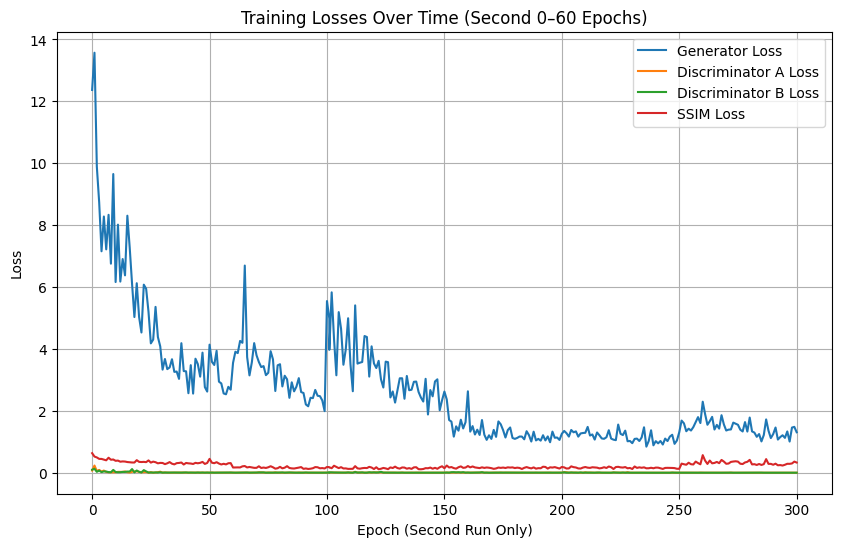

In [3]:
log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/merged_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes of where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If two "Epoch 0" found, keep only the second set of logs
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]  # Keep logs only from the second run

# Parse the cleaned logs
epochs, loss_G, loss_D_A, loss_D_B, ssim_loss = [], [], [], [], []

for line in lines:
    if "Epoch" in line and "Loss_G" in line:
        parts = line.strip().split(", ")
        try:
            epoch_num = int(parts[0].split(" ")[1])
            loss_g = float(parts[2].split(": ")[1])
            loss_d_a = float(parts[3].split(": ")[1])
            loss_d_b = float(parts[4].split(": ")[1])
            ssim = float(parts[5].split(": ")[1])

            epochs.append(epoch_num)
            loss_G.append(loss_g)
            loss_D_A.append(loss_d_a)
            loss_D_B.append(loss_d_b)
            ssim_loss.append(ssim)
        except:
            continue  # Skip lines that don't match format

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_G, label='Generator Loss')
plt.plot(epochs, loss_D_A, label='Discriminator A Loss')
plt.plot(epochs, loss_D_B, label='Discriminator B Loss')
plt.plot(epochs, ssim_loss, label='SSIM Loss')
plt.xlabel("Epoch (Second Run Only)")
plt.ylabel("Loss")
plt.title("Training Losses Over Time (Second 0–60 Epochs)")
plt.legend()
plt.grid(True)
plt.show()


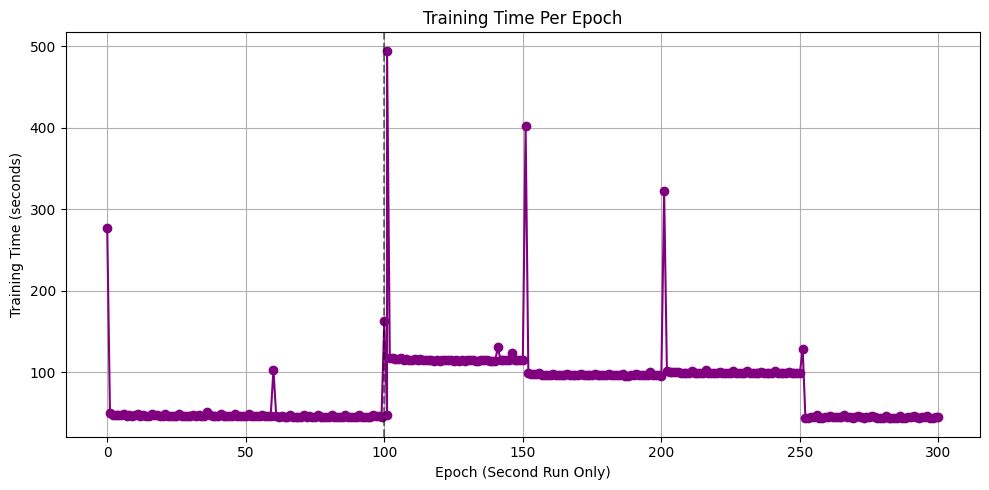

In [11]:
log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/merged_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes of where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If two or more "Epoch 0" found, keep only the second or third run
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]

# Parse Epoch vs Time
epochs, times = [], []

for line in lines:
    if "Epoch" in line and "Time:" in line:
        try:
            parts = line.strip().split(", ")
            epoch_num = int(parts[0].split(" ")[1])
            time_sec = float(parts[1].split(": ")[1].replace("s", ""))  # remove 's' from seconds
            epochs.append(epoch_num)
            times.append(time_sec)
        except:
            continue  # Skip malformed lines

# Plot Time vs Epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, times, marker='o', linestyle='-', color='purple')
plt.xlabel("Epoch (Second Run Only)")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Per Epoch")
plt.axvline(100, color='black', linestyle='--', alpha=0.5, label='Checkpoint')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""
    return ssim(img1, img2, data_range=img2.max() - img2.min())  # ✅ Removed multichannel=True

# Paths to images
input_image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/10.png"
de_rained_image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/results_17/Rain100L_fine_tuned_1.png"

# Load images
input_img = cv2.imread(input_image_path)
de_rained_img = cv2.imread(de_rained_image_path)

# ✅ Resize de-rained image to match input image dimensions
de_rained_img = cv2.resize(de_rained_img, (input_img.shape[1], input_img.shape[0]))

# Convert to grayscale
input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
de_rained_gray = cv2.cvtColor(de_rained_img, cv2.COLOR_BGR2GRAY)

# ✅ Compute SSIM correctly (Grayscale)
ssim_score = calculate_ssim(input_gray, de_rained_gray)

# ✅ Compute PSNR in grayscale (for consistency)
psnr_score = calculate_psnr(input_gray, de_rained_gray)

# Print results
print(f"SSIM Score: {ssim_score:.4f}")
print(f"PSNR Score: {psnr_score:.2f} dB")


SSIM Score: 0.1725
PSNR Score: 27.85 dB


In [ ]:
import cv2
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""
    return ssim(img1, img2, data_range=img2.max() - img2.min())

# Directories
rainy_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/"
de_rained_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/results_17/"

# List of images
rainy_images = sorted(os.listdir(rainy_dir))
de_rained_images = sorted(os.listdir(de_rained_dir))

# Initialize accumulators
total_ssim = 0
total_psnr = 0
count = 0

# Process each image pair
for img_name in rainy_images:
    rainy_path = os.path.join(rainy_dir, img_name)
    de_rained_path = os.path.join(de_rained_dir, "Rain100L_fine_tuned_" + img_name)  # Adjust naming pattern if needed

    if not os.path.exists(de_rained_path):
        print(f"Skipping {img_name}, de-rained version not found.")
        continue

    # Load images
    rainy_img = cv2.imread(rainy_path)
    de_rained_img = cv2.imread(de_rained_path)

    if rainy_img is None or de_rained_img is None:
        print(f"Skipping {img_name}, image read error.")
        continue

    # Resize to match dimensions
    de_rained_img = cv2.resize(de_rained_img, (rainy_img.shape[1], rainy_img.shape[0]))

    # Convert to grayscale
    rainy_gray = cv2.cvtColor(rainy_img, cv2.COLOR_BGR2GRAY)
    de_rained_gray = cv2.cvtColor(de_rained_img, cv2.COLOR_BGR2GRAY)

    # Compute SSIM and PSNR
    ssim_score = calculate_ssim(rainy_gray, de_rained_gray)
    psnr_score = calculate_psnr(rainy_gray, de_rained_gray)

    # Accumulate scores
    total_ssim += ssim_score
    total_psnr += psnr_score
    count += 1

    print(f"✅ {img_name}: SSIM={ssim_score:.4f}, PSNR={psnr_score:.2f} dB")

# Compute averages
if count > 0:
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    print(f"**Overall SSIM:** {avg_ssim:.4f}")
    print(f"**Overall PSNR:** {avg_psnr:.2f} dB")
else:
    print("No valid image pairs found!")


✅ 1.png: SSIM=0.6731, PSNR=30.22 dB
✅ 10.png: SSIM=0.6074, PSNR=29.35 dB
✅ 100.png: SSIM=0.6214, PSNR=29.06 dB
✅ 11.png: SSIM=0.6942, PSNR=29.33 dB
✅ 12.png: SSIM=0.6526, PSNR=30.09 dB
✅ 13.png: SSIM=0.6507, PSNR=30.30 dB
✅ 14.png: SSIM=0.6441, PSNR=29.74 dB
✅ 15.png: SSIM=0.6884, PSNR=30.92 dB
✅ 16.png: SSIM=0.6943, PSNR=29.02 dB
✅ 17.png: SSIM=0.8110, PSNR=29.96 dB
✅ 18.png: SSIM=0.6842, PSNR=28.94 dB
✅ 19.png: SSIM=0.5989, PSNR=29.45 dB
✅ 2.png: SSIM=0.6395, PSNR=31.14 dB
✅ 20.png: SSIM=0.6572, PSNR=30.41 dB
✅ 21.png: SSIM=0.5184, PSNR=29.63 dB
✅ 22.png: SSIM=0.6333, PSNR=28.61 dB
✅ 23.png: SSIM=0.7512, PSNR=29.22 dB
✅ 24.png: SSIM=0.5946, PSNR=29.25 dB
✅ 25.png: SSIM=0.6442, PSNR=28.65 dB
✅ 26.png: SSIM=0.5830, PSNR=29.18 dB
✅ 27.png: SSIM=0.6621, PSNR=29.63 dB
✅ 28.png: SSIM=0.5178, PSNR=28.54 dB
✅ 29.png: SSIM=0.6745, PSNR=29.77 dB
✅ 3.png: SSIM=0.6757, PSNR=28.60 dB
✅ 30.png: SSIM=0.6594, PSNR=28.75 dB
✅ 31.png: SSIM=0.8133, PSNR=29.31 dB
✅ 32.png: SSIM=0.6383, PSNR=30.60 dB
✅ 3

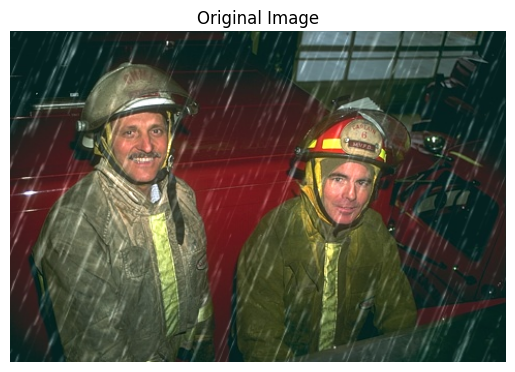

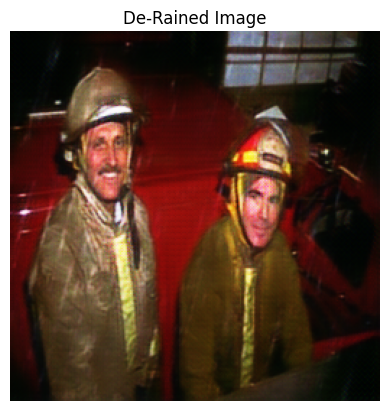

Inference complete! De-rained image saved.


In [13]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from models.networks import ResnetGenerator
import matplotlib.pyplot as plt


# ✅ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_G_A = ResnetGenerator(input_nc=3, output_nc=3, ngf=128, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).to(device)
checkpoint = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location=device)
model_G_A.load_state_dict(checkpoint['model_G_A_state_dict'])
model_G_A.eval()

# ✅ Define image transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load new rainy image
image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/96.png"
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# ✅ Perform inference
with torch.no_grad():
    de_rained_tensor = model_G_A(img_tensor)

# ✅ Convert back to an image
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
de_rained_tensor = de_rained_tensor * std + mean  # Denormalization
de_rained_tensor = torch.clamp(de_rained_tensor, 0, 1)

# ✅ Save the de-rained image
de_rained_image = to_pil_image(de_rained_tensor.squeeze(0).cpu())
de_rained_image.save("/content/drive/MyDrive/Khabeer - IRP/Dataset/Test/9t6.png")

plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

plt.imshow(de_rained_image)
plt.axis('off')
plt.title("De-Rained Image")
plt.show()



print("Inference complete! De-rained image saved.")


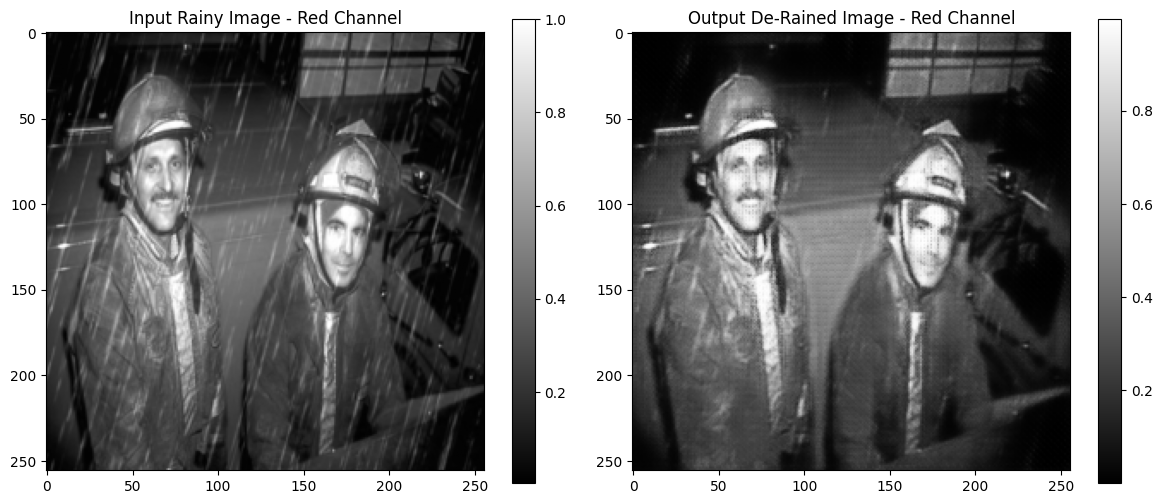

Pixel at (x=100, y=100):
Input RGB: [0.3764706  0.12156862 0.12549019]
Output RGB: [0.47428995 0.04624209 0.03515187]


In [13]:
import numpy as np

# Convert tensors to NumPy for pixel access
input_np = img_tensor.squeeze(0).cpu().detach().numpy()  # shape: (3, H, W)
output_np = de_rained_tensor.squeeze(0).cpu().detach().numpy()  # shape: (3, H, W)

# Denormalize input image too
input_np = (input_np * 0.5) + 0.5
output_np = np.clip(output_np, 0, 1)

# Select Red channel (index 0)
input_red = input_np[0]
output_red = output_np[0]

# Plot pixel intensity of red channel for comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_red, cmap='gray')
plt.title("Input Rainy Image - Red Channel")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(output_red, cmap='gray')
plt.title("Output De-Rained Image - Red Channel")
plt.colorbar()

plt.tight_layout()
plt.show()

# Optional: Print pixel values at a specific location
x, y = 100, 100  # Choose any pixel location
print(f"Pixel at (x={x}, y={y}):")
print("Input RGB:", input_np[:, x, y])
print("Output RGB:", output_np[:, x, y])


In [17]:
ckpt = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location="cpu")
first_key = list(ckpt["model_G_B_state_dict"].keys())[0]
first_tensor = ckpt["model_G_B_state_dict"][first_key]
print(f"{first_key} -> {first_tensor.shape}")


model.1.weight -> torch.Size([128, 3, 7, 7])


In [4]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""
    return ssim(img1, img2, data_range=img2.max() - img2.min())  # ✅ Removed multichannel=True

# Paths to images
input_image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/31.png"
de_rained_image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Test/31.png"

# Load images
input_img = cv2.imread(input_image_path)
de_rained_img = cv2.imread(de_rained_image_path)

# Resize de-rained image to match input image dimensions
de_rained_img = cv2.resize(de_rained_img, (input_img.shape[1], input_img.shape[0]))

# Convert to grayscale
input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
de_rained_gray = cv2.cvtColor(de_rained_img, cv2.COLOR_BGR2GRAY)

#  Compute SSIM correctly (Grayscale)
ssim_score = calculate_ssim(input_gray, de_rained_gray)

# Compute PSNR in grayscale (for consistency)
psnr_score = calculate_psnr(input_gray, de_rained_gray)

# Print results
print(f"SSIM Score: {ssim_score:.4f}")
print(f"PSNR Score: {psnr_score:.2f} dB")


SSIM Score: 0.5744
PSNR Score: 27.98 dB
